In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time 
import math
import matplotlib.pyplot as plt
torch.manual_seed(1)
from torch.utils.data import DataLoader
import h5py
from torch.utils.data import TensorDataset
import numpy as np
import cv2
np.random.seed(0)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import torchvision
from torchvision import datasets, transforms
from torchvision import models as torchmodels

In [16]:
def train_model(model,epochs,trainloader,validationloader,verbose=False,plot=False,save=False,loc='chpt'):
    '''
    args:
    
    model: pytorch model
    epochs: no of epochs
    trainloader: Data loader for train set
    validationloader: Data loader for validation set
    verbose: False/True : If true will print progress as we train 
    plot: If true will plot the model's loss, accuracy graphs.
    
    returns: 
            list[train_acc,valid_acc,train_loss,valid_loss]
    '''
    # LOSS FUNCTION
    
    loss_function = nn.BCELoss(reduction='mean')
    
    #OPTIMIZER
    
    optimizer = optim.Adam(model.parameters())
    vocab_dict=np.load('../data/vocabDict.npy',allow_pickle=True).item()
    
    key_list = list(vocab_dict.keys()) 
    val_list = list(vocab_dict.values()) 
    
    train_loss, valid_loss = [], []
    train_acc,valid_acc=[],[]
    
    
    
    # TRAINING 
    for epoch in range(1, epochs+1):
        start_time = time.time()
        if verbose:
            print('epoch',epoch)
        ## training part 
        model.train()
        ta=0
        correctt=0
        correctv=0
        losst=0
        lossv=0
        t_k=0
        v_k=0
        c=1
        nb=math.ceil(train_size/batch_size)
        for data, target,idx_map in trainloader:
            if verbose:
                print('\r'+'batch_no :'+str(c)+' /'+str(nb),end='')
            c+=1
            t_k=t_k+1
            optimizer.zero_grad()
            
            imgs=load_batch_img('../data/train_images.hdf5',idx_map.cpu().numpy())
            
            img=imgs.cpu().numpy()[0]
            img=np.moveaxis(img, 0, -1)
            plt.imshow(img.astype(int))
            plt.show()
            print(img.max())
            if target[0][0]==1:
                print('No')
            else:
                print('Yes')
            s=''
            for i in data.cpu().numpy()[0]:
                s=s+' '+key_list[val_list.index(i)]
            print(s)
                
                
            output = model(imgs,data)
            del imgs
            torch.cuda.empty_cache()
            loss = loss_function(output, target)
            loss.backward()
            losst=losst+loss.item()
            optimizer.step()
            #print(output)
            #print(data.shape)
            acc=(output.argmax(dim=1) == target.argmax(dim=1)).float().sum().item()
            correctt =correctt + acc
        train_acc.append(correctt/train_size)
        train_loss.append(loss.item())
        if verbose or (epoch-1)%10==0:
            print('time for epoch',time.time()-start_time)
            print('train_loss',losst/t_k)
            print('training accuracy',correctt/train_size)

            
            
            
            
        ## VALIDATION CHECK  
        model.eval()
        

        for data, target,idx_map  in validationloader:
            v_k=v_k+1
            
            imgs=load_batch_img('../data/train_images.hdf5',idx_map.cpu().numpy())
                
            output = model(imgs,data)
            del imgs
            torch.cuda.empty_cache()
            loss = loss_function(output, target)
            lossv=lossv+loss.item()
            accv=(output.argmax(dim=1) == target.argmax(dim=1)).float().sum().item()
            correctv =correctv + accv
        valid_loss.append(lossv/v_k+1)
        valid_acc.append(correctv/val_size)
        
        if verbose or (epoch-1)%10==0:
            print('valid_loss',lossv/v_k+1)
            print('validation accuracy',correctv/val_size)
            
            
    # SAVING CHECKPOINT
    
    if save:
        torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'model':model
                }, loc)
    
    print('train_loss',losst/t_k)
    print('valid_loss',lossv/v_k+1)
    print('training accuracy',correctt/train_size)
    print('validation accuracy',correctv/val_size)
    
    
    
    #PLOTTING 
    if plot:
        epc=np.arange(1,epochs+1)
        plt.plot(epc,train_acc)
        plt.plot(epc,valid_acc)
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        
        plt.plot(epc,train_loss)
        plt.plot(epc,valid_loss)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        
        
        
    return train_acc,valid_acc,train_loss,valid_loss

In [3]:
def test_model(model,x_test_i,x_text_t,y_test):
    '''
    args:
    
    model: pytorch model
    x_test: test  set features
    y_test: test set labels
    
    returns:
            -
    prints:
         accuracy
         precision
         recall
         f-score
         confusion matrix

    '''
    out=np.zeros((y_test.shape))
    ind=0
    x_vl = torch.tensor(x_test_i, dtype=torch.long,device=device)
    x_vl_t = torch.tensor(x_test_t, dtype=torch.long,device=device)
    y_vl = torch.tensor(y_test, dtype=torch.float32,device=device)
    testt = TensorDataset(x_vl,x_vl_t, y_vl)
    testloader = DataLoader(testt, batch_size=128)
    
    model.eval()
    v_k=0
    lossv=0
    correctv=0
    y_out=[]
    for data,data2, target in testloader:
        ind_l=ind+target.shape[0]
        v_k=v_k+1
        output = model(data,data2)
        out2=output.cpu()
        out2=out2.detach().numpy()
        out2=np.squeeze(out2)
        #print(out2.shape,'aaa')
        #print(out[ind:ind_l].shape,'aaaaa')
        #print(ind,ind_l)
        out[ind:ind_l]=out2
        ind=ind_l
        accv=(output.argmax(dim=1) == target.argmax(dim=1)).float().sum().item()
        correctv =correctv + accv
    print('accuracy')
    print(correctv/x_test.shape[0])
    y_true=y_test.argmax(axis=1)
    y_pred=out.argmax(axis=1)
    print('confusion matrix :\n',confusion_matrix(y_true,y_pred),'\n')
    print('f1 score matrix :\n',f1_score(y_true,y_pred,average='micro'),'\n')
    print('precision_score :\n',precision_score(y_true,y_pred,pos_label=1,average='micro'),'\n')
    print('recall_score :\n',recall_score(y_true,y_pred,pos_label=1,average='micro'),'\n')
    print('classification_report :\n',classification_report(y_true,y_pred),'\n')

In [4]:
def VGG_EXT(vgg):
    
    return nn.Sequential((*list(vgg.children())[:-1]))


### BASIC MODEL

In [5]:
class base_enc(nn.Module):
    def __init__(self, vocab_size, embedding_dim,feat_ext_model,
                 hidden_size_lstm,emb_w=None,emb_Train=False,feat_ext_Train=False,dropout=0.5):
        super(base_enc,self).__init__()
        
        #IMAGE FEATURE EXTRACTOR 
        self.feature_extractor = feat_ext_model 
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = feat_ext_Train
        
        self.conv_linear1=nn.Linear(25088,4096)
        self.conv_linear2=nn.Linear(4096,500)
        #TEXT FEATURE EXTRACTOR 

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if emb_w is not None:
            et = torch.tensor(emb_w, dtype=torch.float32,device=device)
            self.embedding.weight = nn.Parameter(et)
            self.embedding.weight.requires_grad = emb_Train
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(dropout)
        self.h_size=hidden_size_lstm
        self.embed_size=embedding_dim
        self.lstm = nn.LSTM(self.embed_size, self.h_size)        
        self.text_linear1= nn.Linear(self.h_size, 500)
        
        # General 
        self.nn1=nn.Linear(1000,500)
        self.nn2=nn.Linear(500,2)
        
        self.relu = nn.ReLU()
        self.tanh=nn.Tanh()
        self.softmax = nn.Softmax()
        
        
    def img_feat_ext(self,image):
        im1= self.feature_extractor(image)
        #print(im1.shape)
        im1=im1.view(im1.size(0), -1)
        im2=self.relu(self.conv_linear1(im1))
        return self.relu(self.conv_linear2(im2))
    
    def text_feat_ext(self,text):
        h_embedding = self.dropout(self.embedding(text))       
        h_lstm, _ = self.lstm(h_embedding)
        last_state, _ = torch.max(h_lstm, 1)   
        return self.relu(self.text_linear1(last_state))
  
        
    def forward(self, image,text):
                
        image_emb=self.img_feat_ext(image)
        text_emb=self.text_feat_ext(text)
        
        ######## Concatenating feature embeddings
        
        #print(image_emb.shape)
        joint_emb=torch.cat((image_emb, text_emb), 1)
        #print(joint_emb.shape)
        
        out1=self.relu(self.nn1(joint_emb))
        out2=self.nn2(out1)
    
      
        return self.softmax(out2)

### LOADING DATA INTO MEMORY

if we have numpy arrays of training images, training text, and class labels it will be easier to load.

#### images of shape (no ofinstances ,3,224,224)

#### text of shape ( no of instances ,fixed_text_length_n).  ie(no_of_instances,(idx_word1,idx_word2,............,idx_word_n))

#### labels of shape (no of instances, class idx)

In [6]:
def load_batch(X_train_images,batch_no,batch_size=64): #batch number starting from 0,1,2,3.. batch size default = 64
    data={}
    start_in= batch_no*batch_size
    end_in= (batch_no+1)*batch_size
    #print (start_in, end_in)
    count = 0
    for i in X_train_images:
        if ((count >=start_in) and (count <end_in)): 
            data.update({i: X_train_images[i]}) 
        count +=1;
    return data;

In [7]:
def load_batch_img(file_loc,idx_map):
    imgs=np.zeros((idx_map.shape[0],3,224,224))
    with h5py.File(file_loc, 'r') as f:
        data = f['images']
        for i in range(idx_map.shape[0]):
            imgs[i]=data[idx_map[i]]
    return torch.tensor(imgs,dtype=torch.float,device=device)
    

In [8]:
#X_train_images=np.load('../data/X_train_img.npy')
X_train_text=np.load('../data/Question_train_pad.npy')
y_train=np.load('../data/answers_train.npy')
X_train_idx=np.load('../data/question_image_map_train_array.npy')

#X_test_images=np.load('../data/X_test_img.npy')


#X_val_images=np.load('../data/X_val_img.npy')
#X_val_text=np.load('../data/X_val_text.npy')
#y_val=np.load('../data/y_val2.npy')
#X_val_idx=np.load('../data/val_img_map.npy')


#emb_w=np.load('../data/word_embeddings.npy')
glove=np.load('../data/glove_embedding.npy')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
y_o=np.zeros((y_train.shape[0],2))
for i in range(y_train.shape[0]):
    if y_train[i]:
        y_o[i][1]=1
    else:
        y_o[i][0]=1
  
        

In [10]:
y_o,y_train

(array([[1., 0.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]]), array([False,  True, False, ...,  True, False,  True]))

### LOADING DATA INTO GPU AND CREATING DATA ITERATORS 

we can load into GPU batch by batch if encounter gpu size issues, but it will be slower

In [11]:
batch_size=32
x_tr_t = torch.tensor(X_train_text,dtype=torch.long,device=device)
y_tr = torch.tensor(y_o,dtype=torch.float,device=device)
x_tr_idx=torch.tensor(X_train_idx.astype('int32'),dtype=torch.long,device=device)
x_tr_idx.shape,x_tr_t.shape,y_tr.shape

(torch.Size([166882]), torch.Size([166882, 15]), torch.Size([166882, 2]))

In [12]:
train_size=x_tr_t.shape[0]
val_size=int(0.2*train_size)
train_size=train_size-val_size
dataset = TensorDataset(x_tr_t, y_tr,x_tr_idx)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = DataLoader(train_dataset, batch_size=batch_size)

validloader = DataLoader(valid_dataset, batch_size=batch_size)

### LOADING PRETRAINED VGG

In [13]:
VGG16 = torchmodels.vgg16_bn(pretrained=True)

In [14]:
device=torch.device(device)
VGG_16=VGG_EXT(VGG16)
#vocab_size, embedding_dim,feat_ext_model,hidden_size_lstm,
model_basic=base_enc(8582,300,VGG_16,128,emb_w=glove,emb_Train=True)
model_basic=model_basic.to(device)


### TRAINING MODEL

epoch 1
batch_no :1 /4173

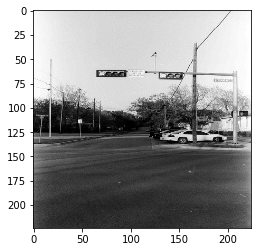

255.0
No
                     is this a color photo


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


batch_no :2 /4173

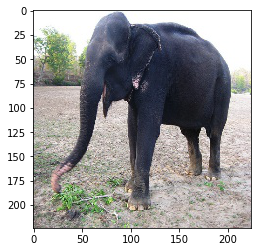

255.0
No
                   does the elephant have any water
batch_no :3 /4173

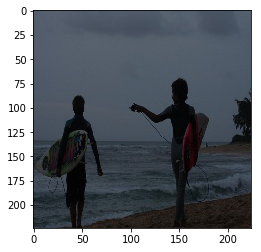

114.0
Yes
                         is it cloudy
batch_no :4 /4173

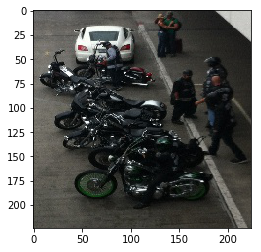

255.0
Yes
                 is the motorbike standing in the shade
batch_no :5 /4173

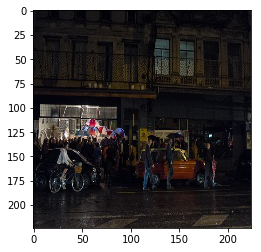

255.0
No
                       is the floor clean
batch_no :6 /4173

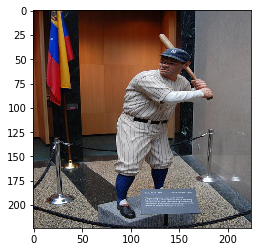

255.0
Yes
       is the man featured in this picture wearing an official sporting uniform
batch_no :7 /4173

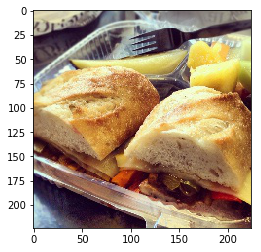

255.0
No
                     do these sandwiches taste disgusting
batch_no :8 /4173

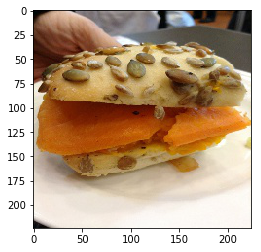

255.0
Yes
                   is there cheese in the picture
batch_no :9 /4173

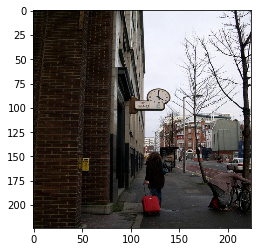

255.0
No
             does the suitcase match the color of his pants
batch_no :10 /4173

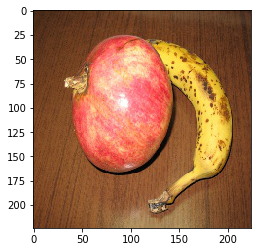

255.0
Yes
                 is there a pomegranate in the photo
batch_no :11 /4173

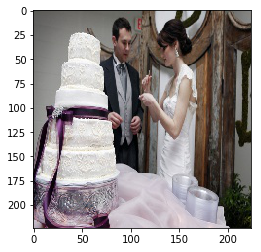

255.0
No
                   is everything on the cake edible
batch_no :12 /4173

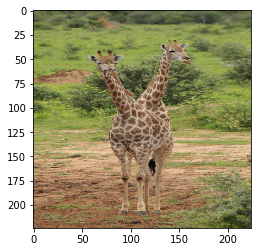

250.0
Yes
                   are these animals in the wild
batch_no :13 /4173

255.0
No
             is this man riding a wave in the ocean
batch_no :14 /4173

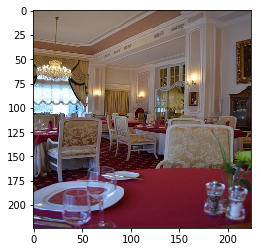

255.0
No
                       is the table cluttered
batch_no :15 /4173

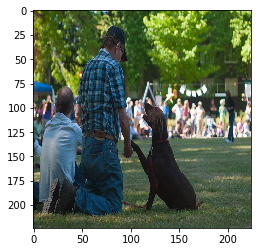

255.0
No
               does this appear to be a winter scene
batch_no :16 /4173

255.0
Yes
                       is this girl talking
batch_no :17 /4173

255.0
Yes
                 is there a boat on the water
batch_no :18 /4173

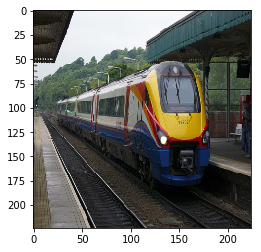

255.0
Yes
                   is this train run by electricity
batch_no :19 /4173

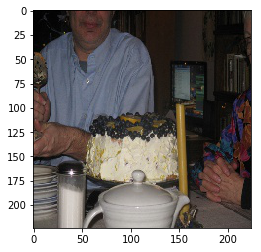

255.0
Yes
                   is there fruit on this cake
batch_no :20 /4173

255.0
Yes
                 is there a wave in the picture
batch_no :21 /4173

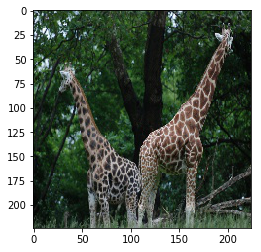

255.0
No
                   are the animals facing each other
batch_no :22 /4173

255.0
No
                   is the guy wearing long pants
batch_no :23 /4173

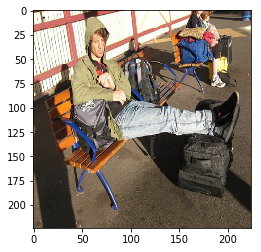

255.0
No
                       is the man sleeping
batch_no :24 /4173

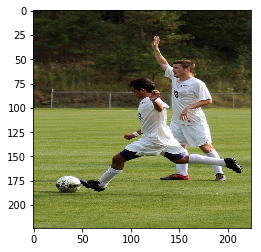

255.0
Yes
                   do the soccer players look competitive
batch_no :25 /4173

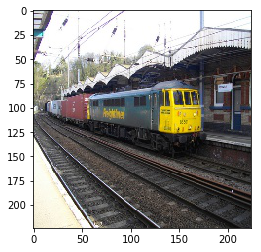

255.0
No
                     is this a passenger train
batch_no :26 /4173

255.0
No
                         are these sailboats
batch_no :27 /4173

255.0
Yes
                   are there numbers in this picture
batch_no :28 /4173

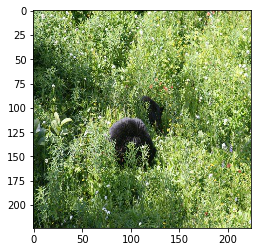

255.0
Yes
                       are these animals related
batch_no :29 /4173

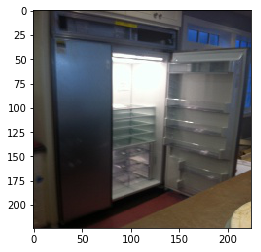

255.0
No
                   is there anything in the fridge
batch_no :30 /4173

255.0
Yes
                       are those baby lambs
batch_no :31 /4173

255.0
Yes
                     are these presents for someone
batch_no :32 /4173

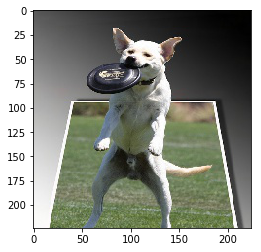

255.0
Yes
                   did the dog catch the frisbee
batch_no :33 /4173

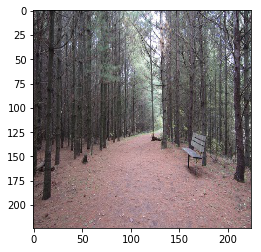

255.0
Yes
                       is this a forest
batch_no :34 /4173

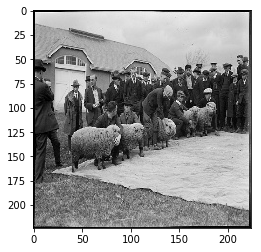

253.0
No
               does this sheep make a good lawn mower
batch_no :35 /4173

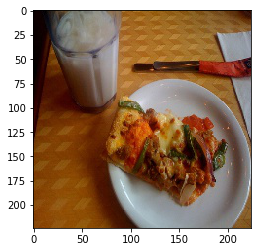

255.0
No
               is there a pizza cutter in the photo
batch_no :36 /4173

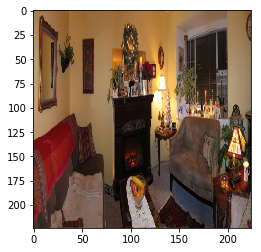

255.0
Yes
                       are all lamps on
batch_no :37 /4173

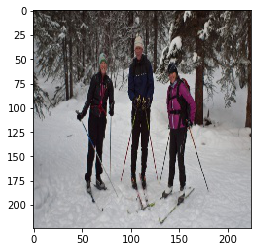

233.0
No
                       is he wearing glasses
batch_no :38 /4173

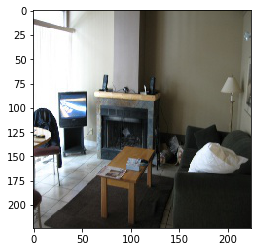

255.0
Yes
                       is the television on
batch_no :39 /4173

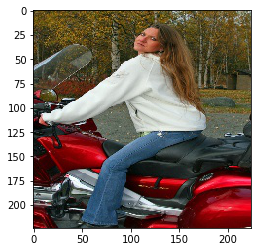

255.0
Yes
                       is the woman riding
batch_no :40 /4173

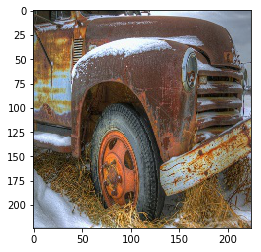

255.0
Yes
                   is that rust on the tire
batch_no :41 /4173

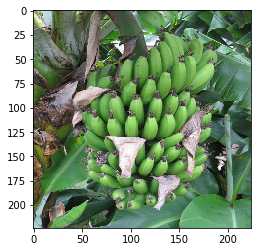

255.0
No
                     are these banana 's ripe
batch_no :42 /4173

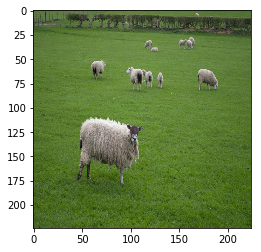

252.0
Yes
                 are the lambs about the same size
batch_no :43 /4173

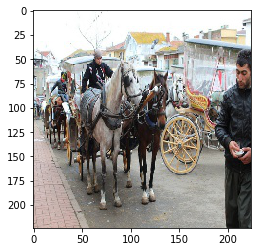

255.0
No
                       are the horses running
batch_no :44 /4173

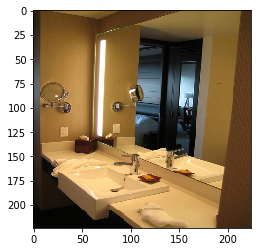

255.0
No
                 are there paper towels for hand drying
batch_no :45 /4173

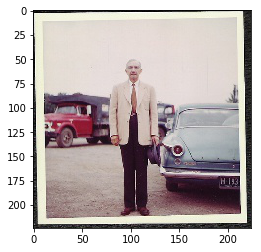

255.0
No
               is the man cooking food in the microwave
batch_no :46 /4173

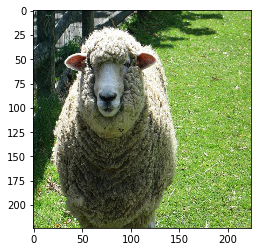

255.0
Yes
                   does this sheep need a haircut
batch_no :47 /4173

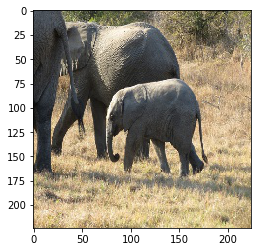

255.0
No
                     is there a giraffe here
batch_no :48 /4173

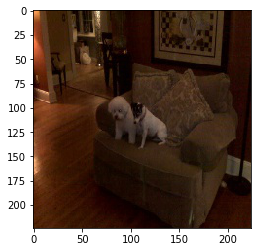

255.0
Yes
                     is there a light on
batch_no :49 /4173

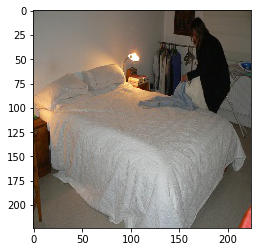

255.0
Yes
               is this something a person should be doing
batch_no :50 /4173

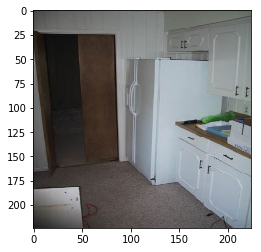

215.0
No
                     are there any lights on
batch_no :51 /4173

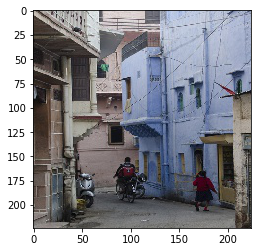

254.0
No
             would you drive a 4x4 truck down this street
batch_no :52 /4173

255.0
Yes
                       is the couple smiling
batch_no :53 /4173

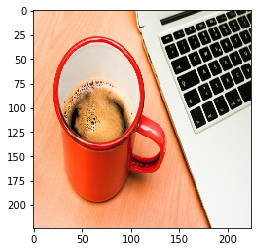

255.0
Yes
                 is there any liquid in the cup
batch_no :54 /4173

KeyboardInterrupt: 

In [17]:
epochs=10
_=train_model(model_basic,epochs,trainloader,validloader,plot=True,verbose=True,save=True,loc='../checkpoints/basic_model.pt')

In [ ]:
torch.save({
                'epoch': 8,
                'model_state_dict': model_basic.state_dict(),
                #'optimizer_state_dict': optimizer.state_dict(),
                'model':model_basic
                }, '../checkpoints/basic_model2.pt')

In [ ]:
a=np.zeros((3,224,224))

In [ ]:
a=np.moveaxis(a, 0, -1)
print(a.shape)

In [ ]:
vocab_dict[0]

In [ ]:
vocab_dict=np.load('../data/vocabDict.npy',allow_pickle=True).item()
    
key_list = list(vocab_dict.keys()) 
val_list = list(vocab_dict.values())

In [ ]:
vocab_dict['wave"']

In [ ]:
im_dict=np.load('../data/img_dict_train.npy',allow_pickle=True).item()

In [ ]:
im_dict

In [ ]:
 with h5py.File('../data/train_images.hdf5', 'r') as f:
        data = f['images']
        im=data[0]
        im=np.moveaxis(im, 0, -1)
        plt.imshow(im)

In [ ]:
ict=np.load('../data/train_qa.npy',allow_pickle=True).item()

In [ ]:
ict